In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import glob
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# Load mask images and get corresponding image file paths
# root_dir = "/content/drive/MyDrive/Dataset_BUSI_with_GT"
masks = glob.glob("/content/drive/MyDrive/PRECISE_Hackathon_Dataset/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together

In [ ]:
def plot_train_label(image_mask):
    image = cv2.imread(image_mask[0])  # Read image
    mask = cv2.imread(image_mask[1])   # Read mask

    f, axarr = plt.subplots(1, 3, figsize=(5, 5))  # Create a figure with 3 subplots

    # Plot the original image
    axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
    axarr[0].set_ylabel('Axial View', fontsize=14)
    axarr[0].set_xticks([])  # Remove x-ticks
    axarr[0].set_yticks([])  # Remove y-ticks
    axarr[0].set_title('Ultrasound Image', fontsize=14)

    # Plot the mask
    axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
    axarr[1].axis('off')  # Turn off axes
    axarr[1].set_title('Mask', fontsize=14)

    # Overlay the mask on the image
    axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
    axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')  # Transparent overlay
    axarr[2].axis('off')
    axarr[2].set_title('Overlay', fontsize=14)

    plt.tight_layout()  # Adjust layout to avoid overlap
    plt.show()

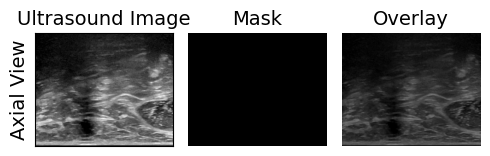

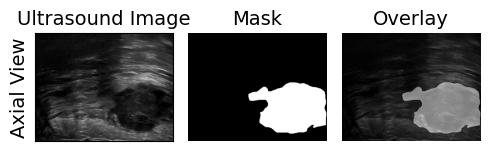

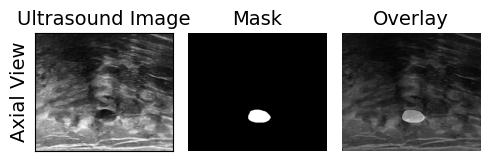

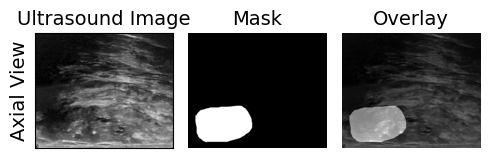

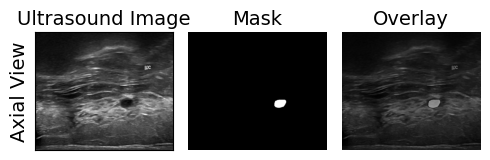

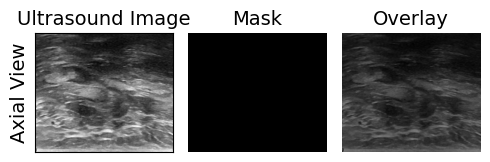

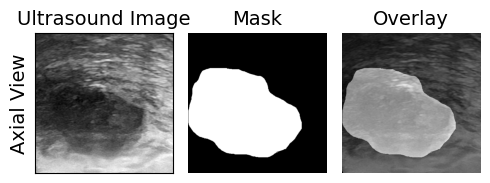

In [ ]:
# Randomly visualize a few image-mask pairs
random_image = random.sample(range(len(series)), 7)  # Randomly select 7 images
for image in random_image:
    plot_train_label(series[image])

In [ ]:
# Convert the image-mask pairs into a DataFrame
dataset = pd.DataFrame(series, columns=['image_path', 'mask_path'])

# Split dataset into train and test sets
train, test = train_test_split(dataset, test_size=0.20, random_state=42)
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")

Train shape: (619, 2)
Test shape: (155, 2)


In [ ]:
class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)  # Total number of samples

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

In [ ]:
image_size = 128  # Define desired image size

train_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),  # Resize to 128x128
    transforms.ToTensor(),  # Convert to Tensor
])

val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),  # Resize for validation set
    transforms.ToTensor(),  # Convert to Tensor
])

In [ ]:
# Create training and testing datasets
train_dataset = CustomImageMaskDataset(train, train_transforms)
test_dataset = CustomImageMaskDataset(test, val_transforms)

# Load datasets in batches
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Visualize the shape of images and masks from one random batch
for batch in train_dataloader:
    inputs, targets = batch  # Get a batch of images and masks

    # Print the shape of the images and masks
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)

    break

Input shape: torch.Size([16, 1, 128, 128])
Target shape: torch.Size([16, 1, 128, 128])


In [4]:
class ConvBlock(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(ConvBlock, self).__init__()
        self.conv2d_1 = nn.Conv2d(input_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(out_channel)
        self.relu_1 = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.conv2d_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(out_channel)
        self.relu_2 = nn.ReLU()

    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.batchnorm_1(x)
        x = self.relu_1(x)
        x = self.dropout(x)
        x = self.conv2d_2(x)
        x = self.batchnorm_2(x)
        x = self.relu_2(x)
        return x

class Encoder(nn.Module):
    def __init__(self, input_channel, out_channel, dropout):
        super(Encoder, self).__init__()
        self.conv2d_1 = ConvBlock(input_channel, out_channel, dropout)
        self.maxpool = nn.MaxPool2d((2, 2))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv2d_1(x)
        p = self.maxpool(x)
        p = self.dropout(p)
        return x, p

class Decoder(nn.Module):
    def __init__(self, input_channel, output_channel, dropout):
        super(Decoder, self).__init__()
        self.conv_t = nn.ConvTranspose2d(input_channel, output_channel, stride=2, kernel_size=2)
        self.conv2d_1 = ConvBlock(output_channel * 2, output_channel, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, skip):
        x = self.conv_t(x)
        x = torch.cat([x, skip], dim=1)
        x = self.dropout(x)
        x = self.conv2d_1(x)
        return x

class Unet(nn.Module):
    def __init__(self, input_channel=1):
        super().__init__()
        self.encoder_1 = Encoder(input_channel, 64, 0.07)
        self.encoder_2 = Encoder(64, 128, 0.08)
        self.encoder_3 = Encoder(128, 256, 0.09)
        self.encoder_4 = Encoder(256, 512, 0.1)
        self.conv_block = ConvBlock(512, 1024, 0.11)
        self.decoder_1 = Decoder(1024, 512, 0.1)
        self.decoder_2 = Decoder(512, 256, 0.09)
        self.decoder_3 = Decoder(256, 128, 0.08)
        self.decoder_4 = Decoder(128, 64, 0.07)
        self.cls = nn.Conv2d(64, 1, kernel_size=1, padding=0)
        self.relu = nn.Sigmoid()

    def forward(self, x):
        x1, p1 = self.encoder_1(x)
        x2, p2 = self.encoder_2(p1)
        x3, p3 = self.encoder_3(p2)
        x4, p4 = self.encoder_4(p3)
        x5 = self.conv_block(p4)
        x6 = self.decoder_1(x5, x4)
        x7 = self.decoder_2(x6, x3)
        x8 = self.decoder_3(x7, x2)
        x9 = self.decoder_4(x8, x1)
        x_final = self.cls(x9)
        x_final = self.relu(x_final)
        return x_final

In [5]:
class Trainer:
    def __init__(self, model, num_epochs, optimizer, criterion, device):
        self.num_epochs = num_epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.model = model
        self.device = device
        self.log_interval = 15

        # Lists to store training and validation metrics
        self.train_losses = []
        self.val_losses = []
        self.train_dices = []
        self.val_dices = []

        # Best model and its metrics
        self.best_model = None
        self.best_dice = 0.0
        self.best_epoch = 0

    def dice_coeff(self, predicted, target, smooth=1e-5):
        intersection = torch.sum(predicted * target)
        union = torch.sum(predicted) + torch.sum(target)
        dice = (2. * intersection + smooth) / (union + smooth)
        return dice

    def iou(self, pred_mask, true_mask):
        intersection = torch.logical_and(pred_mask, true_mask).sum().item()
        union = torch.logical_or(pred_mask, true_mask).sum().item()
        iou_score = intersection / union if union != 0 else 0.0
        return iou_score

    def save_best_model(self, epoch, dice):
        if dice > self.best_dice:
            self.best_dice = dice
            self.best_epoch = epoch
            self.best_model = self.model.state_dict()

            filename = f'best_model_epoch{epoch}_dice{dice:.4f}.pth'
            torch.save(self.best_model, filename)

    def train(self, train_loader, val_loader):
        for epoch in range(self.num_epochs):
            train_loss = 0.0
            val_loss = 0.0
            train_dice = 0.0
            val_dice = 0.0

            # Training loop
            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)

                self.model.train()
                self.optimizer.zero_grad()

                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = self.dice_coeff(outputs, masks)

                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                train_dice += dice

                if (i + 1) % self.log_interval == 0:
                    print(f'Epoch [{epoch + 1}/{self.num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.model(images)
                    val_loss += self.criterion(outputs, masks).item()
                    val_dice += self.dice_coeff(outputs, masks)

            avg_train_loss = train_loss / len(train_loader)
            avg_val_loss = val_loss / len(val_loader)
            avg_train_dice = train_dice / len(train_loader)
            avg_val_dice = val_dice / len(val_loader)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Epoch [{epoch + 1}/{self.num_epochs}], Train Dice: {avg_train_dice:.4f}, Val Dice: {avg_val_dice:.4f}')

            # Save metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.train_dices.append(avg_train_dice)
            self.val_dices.append(avg_val_dice)

            # Save best model
            self.save_best_model(epoch + 1, avg_val_dice)

    def get_metrics(self):
        return {
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_dices': self.train_dices,
            'val_dices': self.val_dices,
        }

In [6]:
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target*inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection/union)

def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score

In [6]:
unet = Unet(1).to(device)

In [ ]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(unet.parameters(), lr=learning_rate, weight_decay=weight_decay)

unet_trainer = Trainer(model=unet, num_epochs=50, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [ ]:
unet_trainer.train(train_dataloader, test_dataloader)
unet_metrics = unet_trainer.get_metrics()

Epoch [1/50], Step [15/39], Loss: 1.6516, Dice Coef: 0.1164
Epoch [1/50], Step [30/39], Loss: 1.4519, Dice Coef: 0.1595
Epoch [1/50], Train Loss: 1.5776, Val Loss: 1.4641
Epoch [1/50], Train Dice: 0.1435, Val Dice: 0.1224
Epoch [2/50], Step [15/39], Loss: 1.3242, Dice Coef: 0.2113
Epoch [2/50], Step [30/39], Loss: 1.4043, Dice Coef: 0.1183
Epoch [2/50], Train Loss: 1.3797, Val Loss: 1.3522
Epoch [2/50], Train Dice: 0.1523, Val Dice: 0.1382
Epoch [3/50], Step [15/39], Loss: 1.2876, Dice Coef: 0.2016
Epoch [3/50], Step [30/39], Loss: 1.3195, Dice Coef: 0.1521
Epoch [3/50], Train Loss: 1.2936, Val Loss: 1.2761
Epoch [3/50], Train Dice: 0.1952, Val Dice: 0.1950
Epoch [4/50], Step [15/39], Loss: 1.2842, Dice Coef: 0.1904
Epoch [4/50], Step [30/39], Loss: 1.2542, Dice Coef: 0.1970
Epoch [4/50], Train Loss: 1.2261, Val Loss: 1.2326
Epoch [4/50], Train Dice: 0.2345, Val Dice: 0.1815
Epoch [5/50], Step [15/39], Loss: 1.1871, Dice Coef: 0.2307
Epoch [5/50], Step [30/39], Loss: 1.1107, Dice Coef:

In [ ]:
# Saved model
torch.save(unet.state_dict(), 'unet_trained_model.pt')

print("Model saved as 'unet_trained_model.pt'")

Model saved as 'unet_trained_model.pt'


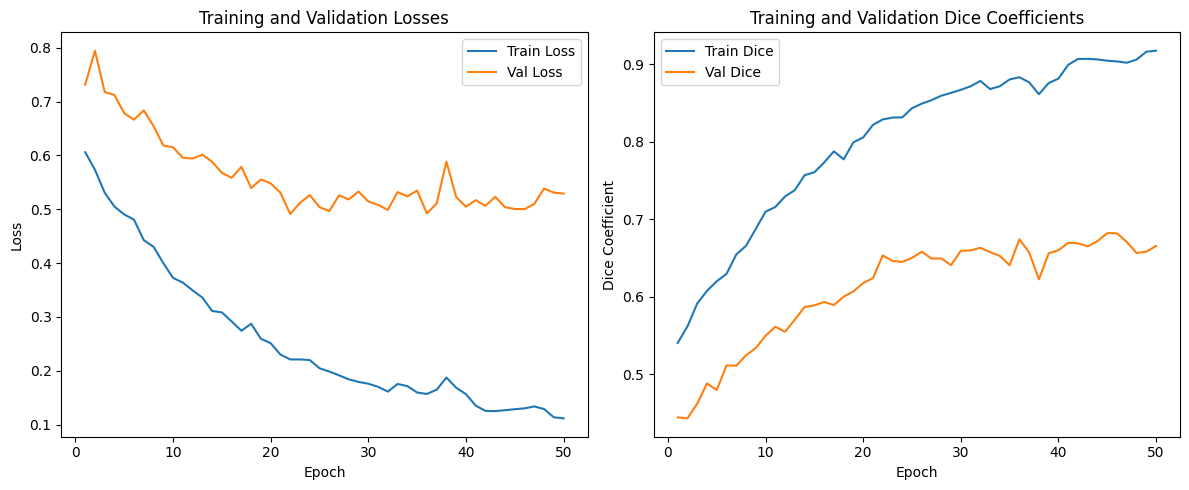

In [ ]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(unet_metrics)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

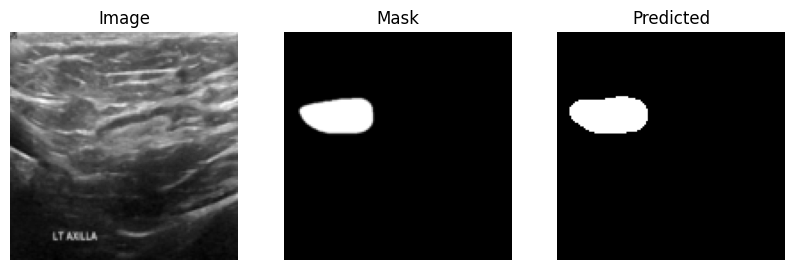

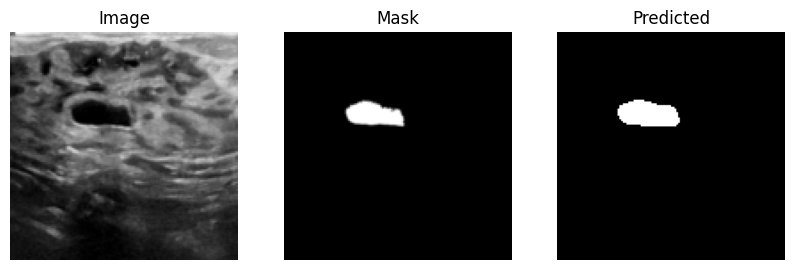

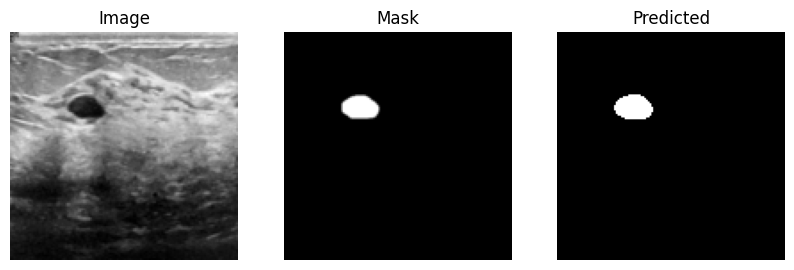

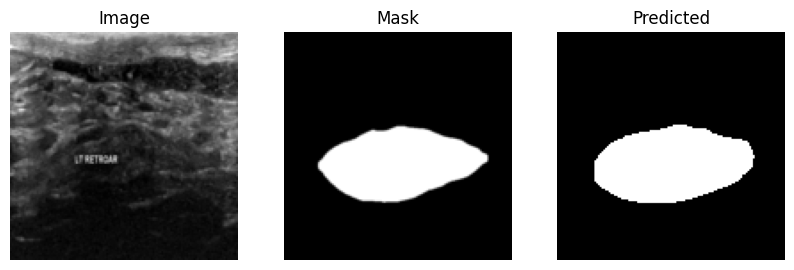

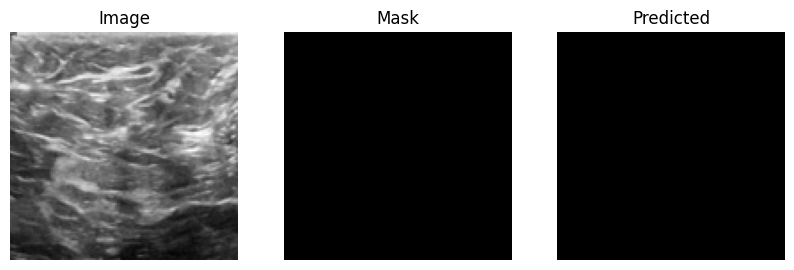

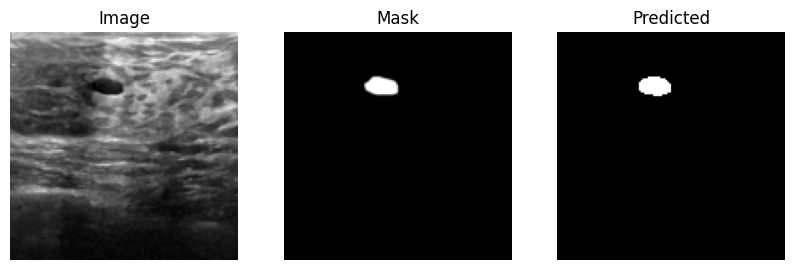

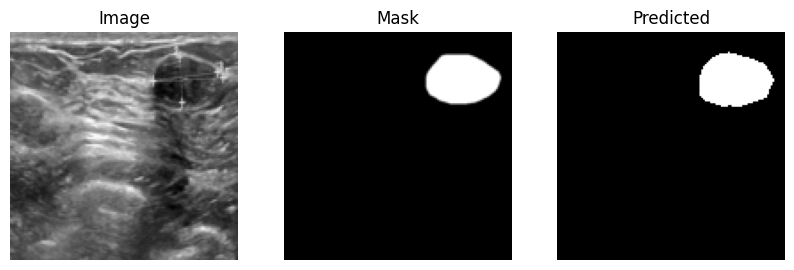

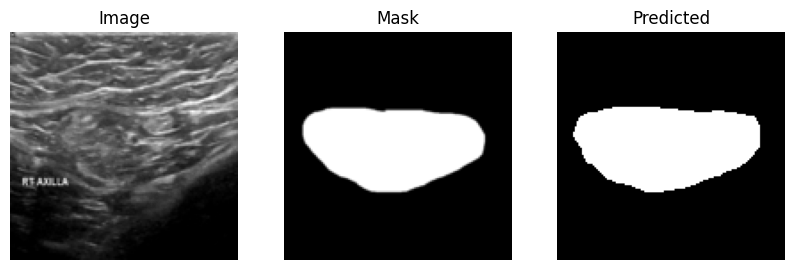

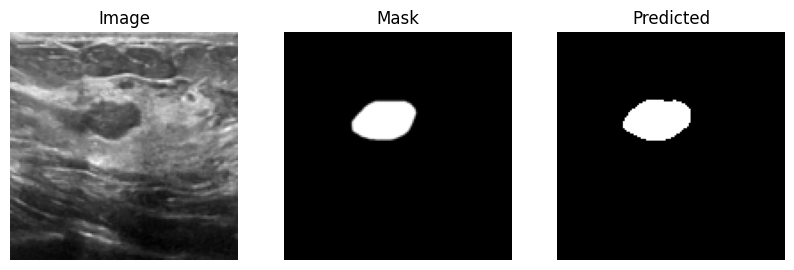

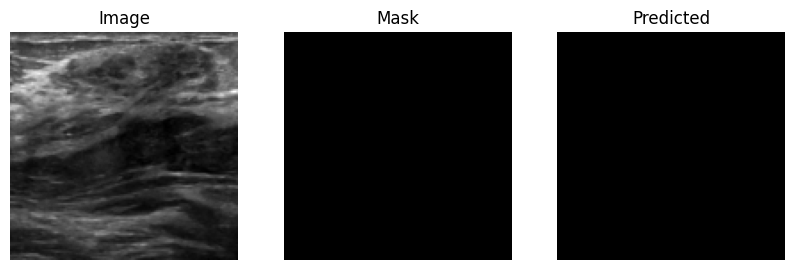

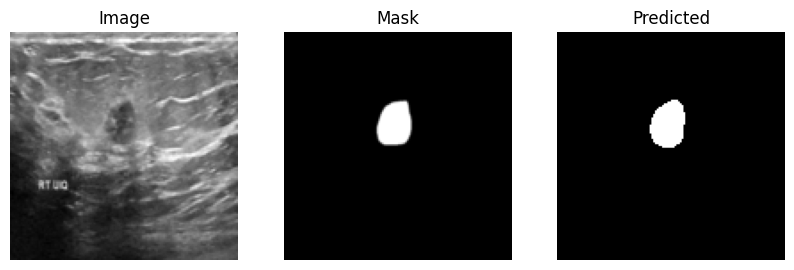

In [ ]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = unet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

### **AttenTionNet**

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g = F.adaptive_avg_pool2d(g, x.size()[2:])
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(AttentionUNet, self).__init__()

        # Encoder path
        self.encoder1 = ConvBlock(in_channels, 64)
        self.encoder2 = ConvBlock(64, 128)
        self.encoder3 = ConvBlock(128, 256)
        self.encoder4 = ConvBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(512, 1024)

        # Decoder path with attention gates
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.attention4 = AttentionBlock(F_g=512, F_l=512, F_int=256)
        self.decoder4 = ConvBlock(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.attention3 = AttentionBlock(F_g=256, F_l=256, F_int=128)
        self.decoder3 = ConvBlock(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.attention2 = AttentionBlock(F_g=128, F_l=128, F_int=64)
        self.decoder2 = ConvBlock(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.attention1 = AttentionBlock(F_g=64, F_l=64, F_int=32)
        self.decoder1 = ConvBlock(128, 64)

        # Output layer
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder path
        e1 = self.encoder1(x)
        e2 = self.encoder2(F.max_pool2d(e1, kernel_size=2))
        e3 = self.encoder3(F.max_pool2d(e2, kernel_size=2))
        e4 = self.encoder4(F.max_pool2d(e3, kernel_size=2))

        # Bottleneck
        b = self.bottleneck(F.max_pool2d(e4, kernel_size=2))

        # Decoder path with attention
        d4 = self.upconv4(b)
        e4 = self.attention4(g=d4, x=e4)
        d4 = self.decoder4(torch.cat((e4, d4), dim=1))

        d3 = self.upconv3(d4)
        e3 = self.attention3(g=d3, x=e3)
        d3 = self.decoder3(torch.cat((e3, d3), dim=1))

        d2 = self.upconv2(d3)
        e2 = self.attention2(g=d2, x=e2)
        d2 = self.decoder2(torch.cat((e2, d2), dim=1))

        d1 = self.upconv1(d2)
        e1 = self.attention1(g=d1, x=e1)
        d1 = self.decoder1(torch.cat((e1, d1), dim=1))

        # Output layer
        out = self.final_conv(d1)
        out = self.sigmoid(out)

        return out

In [8]:
attention_UNet = AttentionUNet().to(device)

In [ ]:
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(attention_UNet.parameters(), lr=learning_rate, weight_decay=weight_decay)

attentionnet_trainer = Trainer(model=attention_UNet, num_epochs=10, optimizer=optimizer, criterion=bce_dice_loss, device=device)

In [ ]:
attentionnet_trainer.train(train_dataloader, test_dataloader)
attentionnet_metrics = attentionnet_trainer.get_metrics()

Epoch [1/10], Step [15/39], Loss: 1.2140, Dice Coef: 0.2890
Epoch [1/10], Step [30/39], Loss: 1.2510, Dice Coef: 0.2257
Epoch [1/10], Train Loss: 1.2777, Val Loss: 1.2800
Epoch [1/10], Train Dice: 0.2144, Val Dice: 0.2221
Epoch [2/10], Step [15/39], Loss: 1.0779, Dice Coef: 0.3143
Epoch [2/10], Step [30/39], Loss: 0.9348, Dice Coef: 0.3983
Epoch [2/10], Train Loss: 1.0672, Val Loss: 0.9848
Epoch [2/10], Train Dice: 0.2911, Val Dice: 0.3017
Epoch [3/10], Step [15/39], Loss: 0.8526, Dice Coef: 0.4044
Epoch [3/10], Step [30/39], Loss: 0.9663, Dice Coef: 0.3069
Epoch [3/10], Train Loss: 0.9736, Val Loss: 0.9626
Epoch [3/10], Train Dice: 0.3268, Val Dice: 0.3170
Epoch [4/10], Step [15/39], Loss: 0.8518, Dice Coef: 0.4025
Epoch [4/10], Step [30/39], Loss: 0.8807, Dice Coef: 0.3674
Epoch [4/10], Train Loss: 0.9387, Val Loss: 0.9863
Epoch [4/10], Train Dice: 0.3444, Val Dice: 0.3256
Epoch [5/10], Step [15/39], Loss: 0.9640, Dice Coef: 0.3111
Epoch [5/10], Step [30/39], Loss: 0.8181, Dice Coef:

In [ ]:
# Saving the trained model's state dictionary as a .pt file
torch.save(attention_UNet.state_dict(), 'attentionnet_trained_model.pt')

print("Model saved as 'attentionnet_trained_model.pt'")

Model saved as 'attentionnet_trained_model.pt'


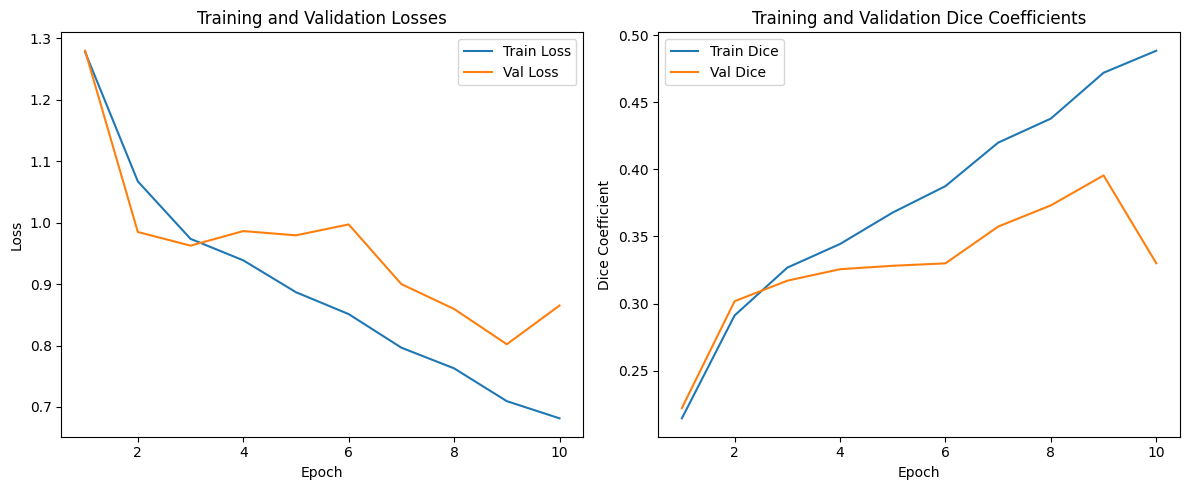

In [ ]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(attentionnet_metrics)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

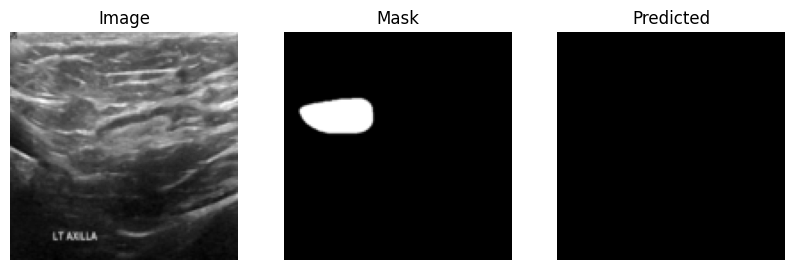

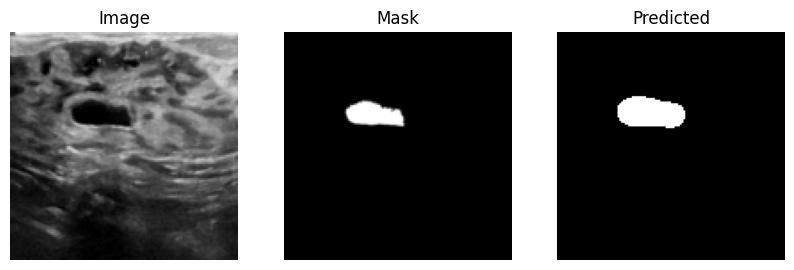

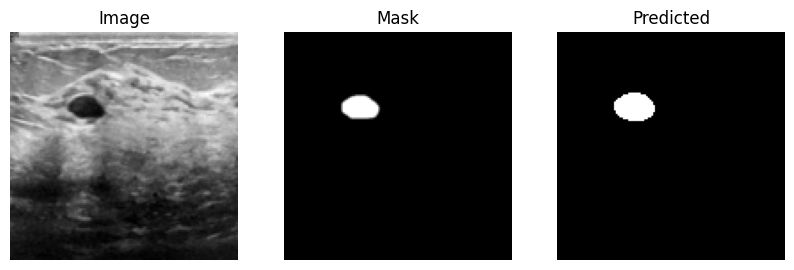

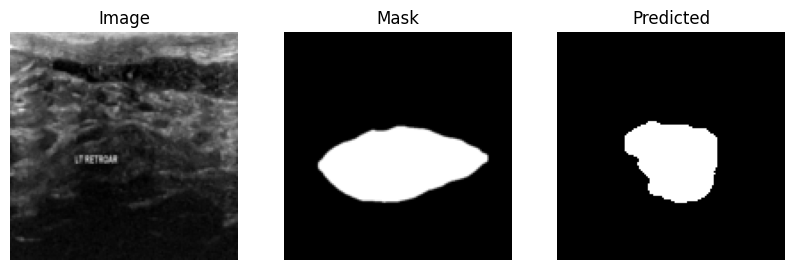

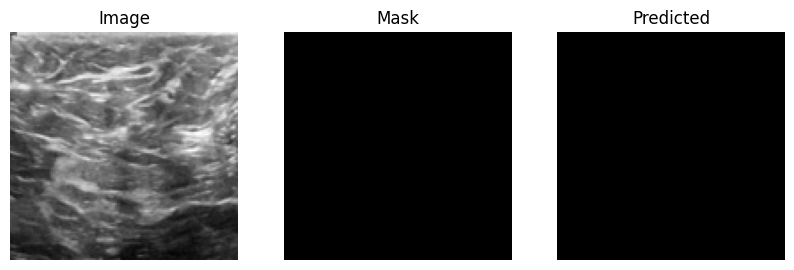

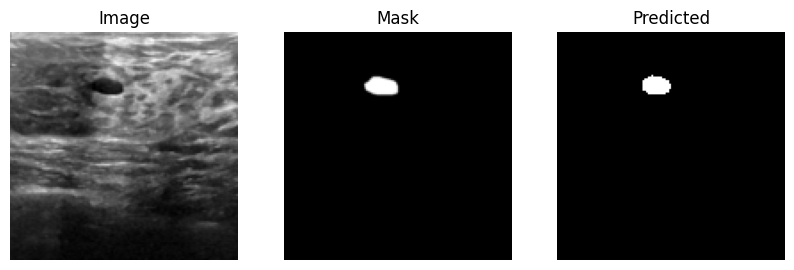

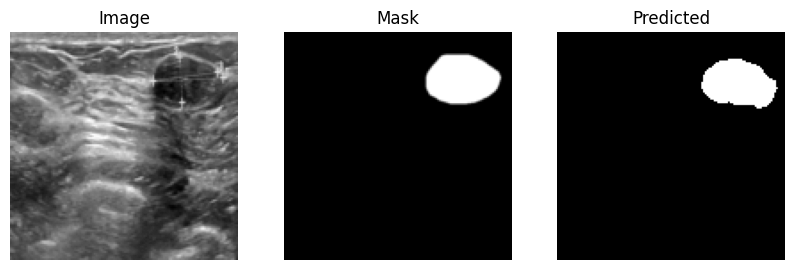

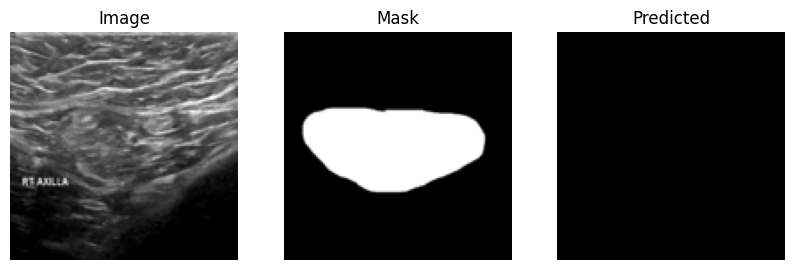

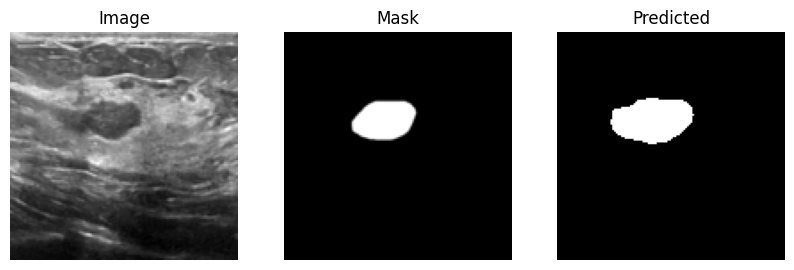

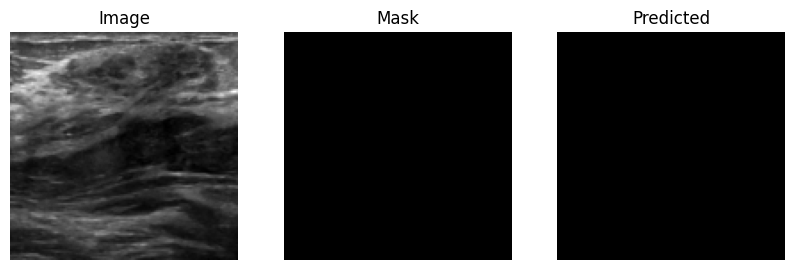

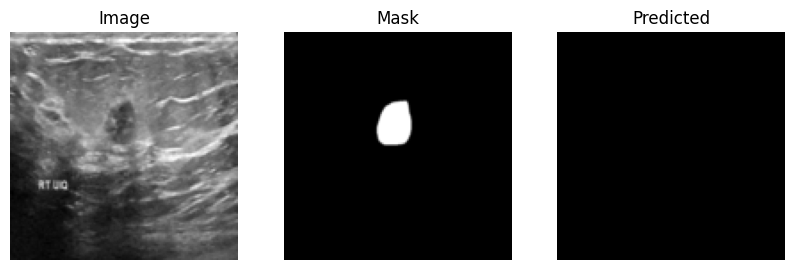

In [ ]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = attention_UNet(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

### **Model Ensemble**

In [9]:
import torch
import torch.nn as nn

# Model Averaging Ensemble
class ModelAveragingEnsemble(nn.Module):
    def __init__(self, models):
        super(ModelAveragingEnsemble, self).__init__()
        self.models = nn.ModuleList(models)  # Proper registration of models

    def forward(self, x):
        avg_output = sum(model(x) for model in self.models) / len(self.models)
        return avg_output

# Model Stacking Ensemble
class ModelStackingEnsemble(nn.Module):
    def __init__(self, models):
        super(ModelStackingEnsemble, self).__init__()
        self.models = nn.ModuleList(models)  # Proper registration of models
        self.fc = nn.Conv2d(len(models), 1, kernel_size=1)  # Combine predictions

    def forward(self, x):
        outputs = [model(x) for model in self.models]
        stacked_output = torch.cat(outputs, dim=1)  # Stack along channel dimension
        final_output = self.fc(stacked_output)
        return final_output


In [11]:
# Model averaging ensemble
learning_rate = 0.0001
weight_decay = 1e-6  # Regularization term to prevent overfitting

optimizer = optim.Adam(attention_UNet.parameters(), lr=learning_rate, weight_decay=weight_decay)

ensemble_model_avg = ModelAveragingEnsemble([attention_UNet, unet]).to(device)
ensemble_optimizer = optim.Adam(ensemble_model_avg.parameters(), lr=learning_rate, weight_decay=weight_decay)

trainer_ensemble_avg = Trainer(model=ensemble_model_avg, num_epochs=10, optimizer=ensemble_optimizer, criterion=bce_dice_loss, device=device)

In [ ]:
trainer_ensemble_avg.train(train_dataloader, test_dataloader)
ensemble_metrics = trainer_ensemble_avg.get_metrics()

Epoch [1/10], Step [15/39], Loss: 0.4182, Dice Coef: 0.6479
Epoch [1/10], Step [30/39], Loss: 0.3150, Dice Coef: 0.7456
Epoch [1/10], Train Loss: 0.3531, Val Loss: 0.6297
Epoch [1/10], Train Dice: 0.7159, Val Dice: 0.5347
Epoch [2/10], Step [15/39], Loss: 0.3039, Dice Coef: 0.7623
Epoch [2/10], Step [30/39], Loss: 0.3140, Dice Coef: 0.7521
Epoch [2/10], Train Loss: 0.3371, Val Loss: 0.5644
Epoch [2/10], Train Dice: 0.7280, Val Dice: 0.5681
Epoch [3/10], Step [15/39], Loss: 0.3147, Dice Coef: 0.7446
Epoch [3/10], Step [30/39], Loss: 0.2078, Dice Coef: 0.8422
Epoch [3/10], Train Loss: 0.3089, Val Loss: 0.5620
Epoch [3/10], Train Dice: 0.7508, Val Dice: 0.5809
Epoch [4/10], Step [15/39], Loss: 0.2976, Dice Coef: 0.7587
Epoch [4/10], Step [30/39], Loss: 0.4949, Dice Coef: 0.5610
Epoch [4/10], Train Loss: 0.2970, Val Loss: 0.5754
Epoch [4/10], Train Dice: 0.7602, Val Dice: 0.5756
Epoch [5/10], Step [15/39], Loss: 0.2299, Dice Coef: 0.8299
Epoch [5/10], Step [30/39], Loss: 0.2309, Dice Coef:

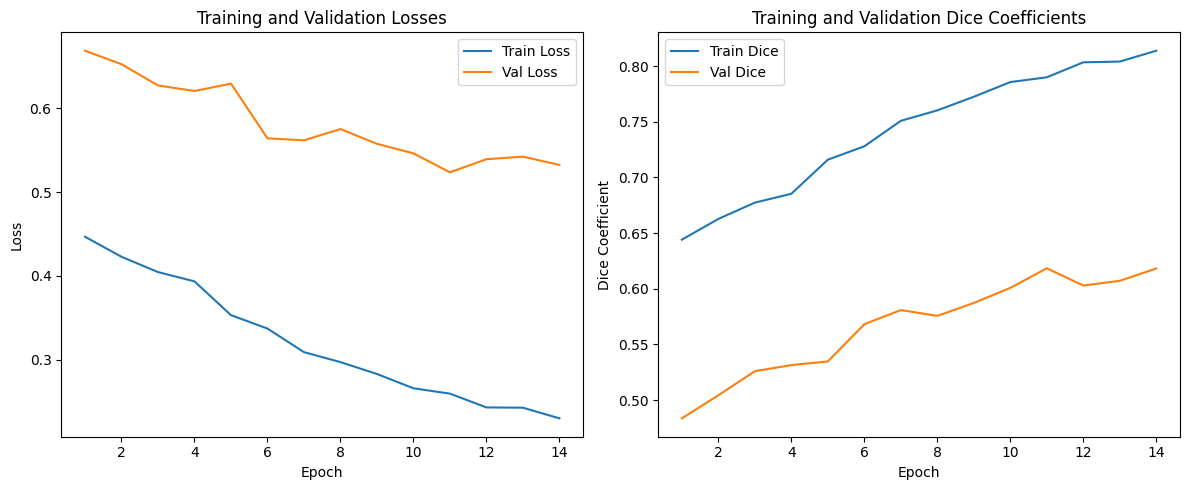

In [ ]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]

    # Plot Losses
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_metrics(ensemble_metrics)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

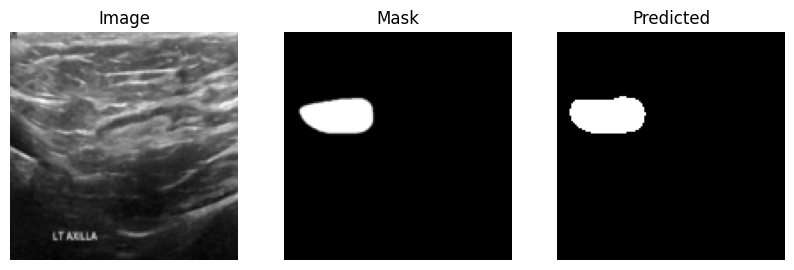

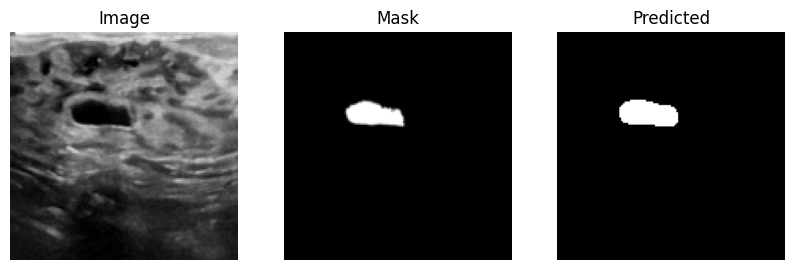

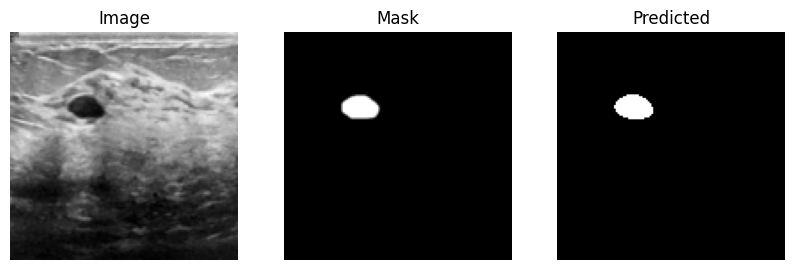

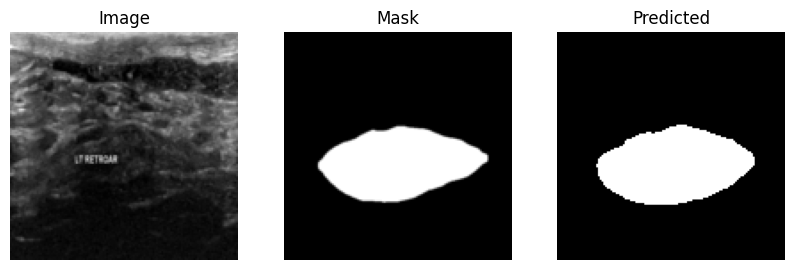

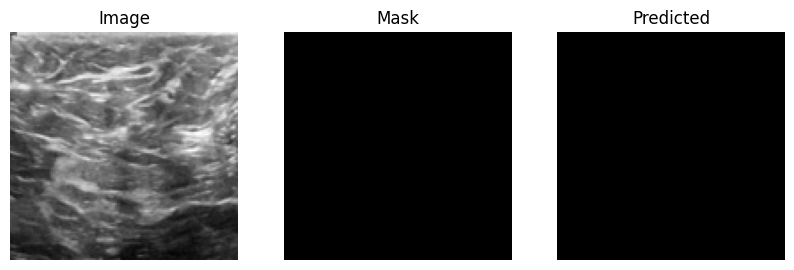

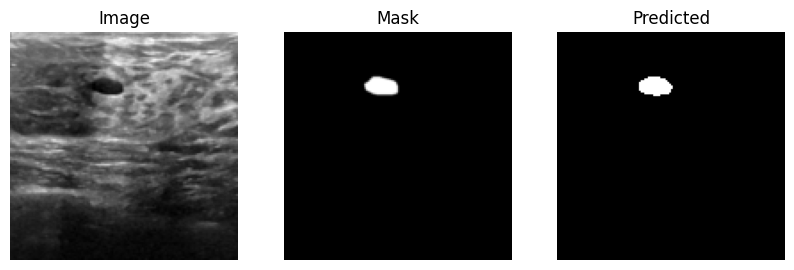

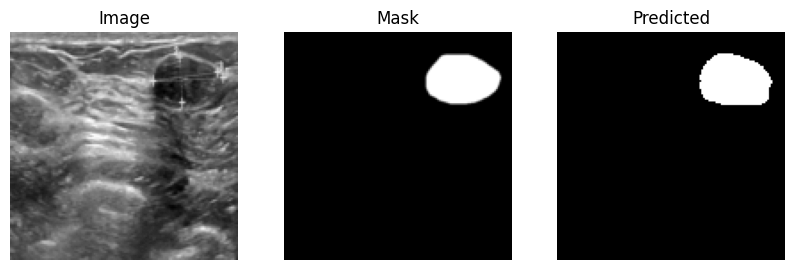

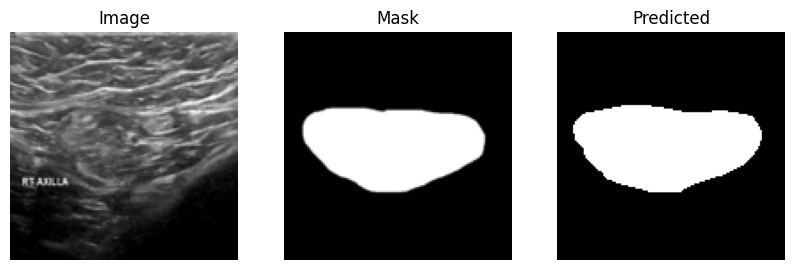

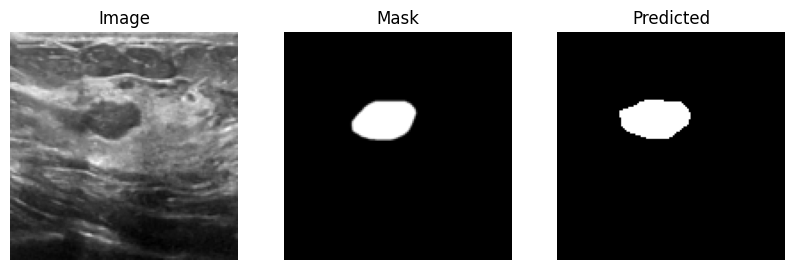

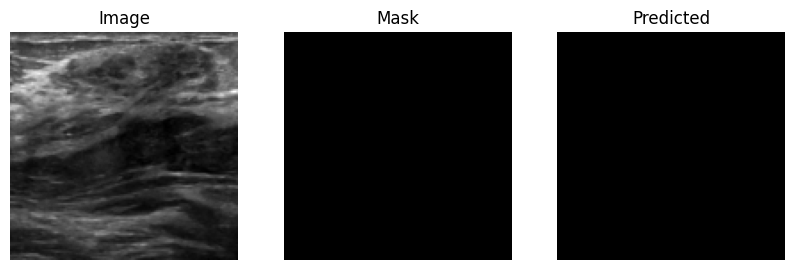

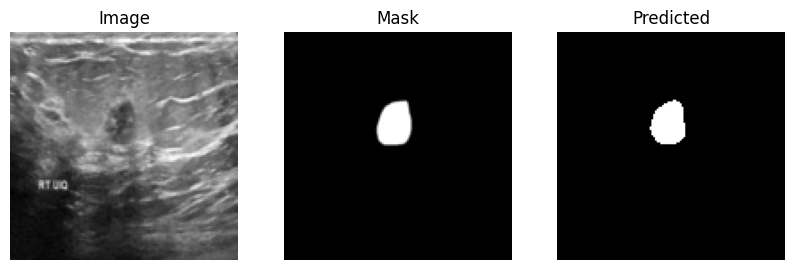

In [ ]:
for i in [2, 3, 11, 20, 55, 67, 87, 98, 120, 130, 200]:
    image = train_dataset[i][0]
    mask = train_dataset[i][1]
    im = image.to(device)
    pred = ensemble_model_avg(im.unsqueeze(0))
    pred = pred.squeeze()

    plot_subplots(im, mask, pred)

In [ ]:
# Saving the trained model's state dictionary as a .pt file
torch.save(ensemble_model_avg.state_dict(), 'ensemble_model_avg_model.pt')

print("Model saved as 'ensemble_model_avg_model.pt'")

Model saved as 'ensemble_model_avg_model.pt'


In [12]:
# Initialize model
model = ModelAveragingEnsemble([attention_UNet, unet]).to(device)

model_path = '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/ensemble_model_avg_model.pt'

# Load saved weights (provide the correct path to your model)
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

ModelAveragingEnsemble(
  (models): ModuleList(
    (0): AttentionUNet(
      (encoder1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU(inplace=True)
        )
      )
      (encoder2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [13]:
# Initialize the model
trained_att_model = ModelAveragingEnsemble([attention_UNet, unet]).to(device)

# Load the saved state_dict
pretrained_path = "/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/ensemble_model_avg_model.pt"
pretrained_weights = torch.load(pretrained_path, map_location=device)

# Load the weights into the model
trained_att_model.load_state_dict(pretrained_weights)
trained_att_model.eval()


import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms

masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Evaluation_dataset/*/*_mask.png")
images = [mask_images.replace("_mask", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together
print(len(series))

# Convert the image-mask pairs into a DataFrame for validation
validation_dataset_df = pd.DataFrame(series, columns=['image_path', 'mask_path'])


class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask, mask_path

# Image transformations for validation
image_size = 128
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),  # Convert to Tensor
])

# Create validation dataset and dataloader
validation_dataset = CustomImageMaskDataset(validation_dataset_df, val_transforms)
batch_size = 1
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

# Define Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target * inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection / union)

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score


def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted



from PIL import Image

# Function to evaluate the model on the validation dataset
def evaluate_model(model, dataloader, out, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    dice_loss_total = 0

    with torch.no_grad():
        for batch in dataloader:
            # Load images and masks from the batch
            images, masks, mask_path = batch
            images = images.to(device)
            masks = masks.to(device)


            save_dir = os.path.join(out, os.path.basename(mask_path[0]))
            print(save_dir)


            # Get model predictions
            outputs = model(images)

            # Threshold the predicted values
            outputs_sv = threshold_prediction(outputs, threshold=0.5).detach().cpu().numpy()


            numpy_array = outputs_sv.squeeze()
            mask = numpy_array.astype(np.uint8) * 255

            #image = Image.fromarray(mask)
            #print(mask.shape)

            #image.save(save_dir)
            cv2.imwrite(save_dir, mask)

            # Calculate Dice and BCE+Dice losses
            dice_loss = dice_coef_loss(outputs, masks)
            bce_dice = bce_dice_loss(outputs, masks)

            # Accumulate the total loss and dice loss
            total_loss += bce_dice.item()
            dice_loss_total += dice_loss.item()

    # Calculate average loss over the entire validation set
    avg_total_loss = total_loss / len(dataloader)
    avg_dice_loss = dice_loss_total / len(dataloader)

    return avg_total_loss, avg_dice_loss


    trained_att_model.to(device)


# Directory to save output segmentation masks
out = '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02'

# Create output directory if it doesn't exist
os.makedirs(out, exist_ok=True)

# Evaluate the model on the validation dataset
avg_total_loss, avg_dice_loss = evaluate_model(trained_att_model, validation_dataloader, out, device)

# Print the evaluation results
print(f"Average Total Loss (BCE + Dice): {avg_total_loss}")
print(f"Average Dice Loss: {avg_dice_loss}")


30
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (1)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (10)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (3)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (4)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (2)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (6)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (5)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (8)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/normal (7)_mask.png
/content/drive/My Drive/CAMERA/PRECISE_Hac

In [14]:
masks = glob.glob("/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/TEAM_2/Team_02/*_grnd.png")
images = [mask_images.replace("_grnd", "") for mask_images in masks]  # Replace "_mask" to get image paths
series = list(zip(images, masks))  # Zip image and mask paths together

#print(series)



# Convert the image-mask pairs into a DataFrame for validation
validation_dataset_df = pd.DataFrame(series, columns=['image_path', 'mask_path'])


class CustomImageMaskDataset(Dataset):
    def __init__(self, dataframe, image_transform=None):
        self.data = dataframe  # DataFrame containing image and mask paths
        self.image_transform = image_transform  # Transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image and mask paths
        image_path = self.data.iloc[idx]['image_path']
        mask_path = self.data.iloc[idx]['mask_path']

        # Load images and convert to grayscale
        image = Image.open(image_path).convert('L')
        mask = Image.open(mask_path).convert('L')

        # Apply transformations (if any)
        if self.image_transform:
            image = self.image_transform(image)
            mask = self.image_transform(mask)

        return image, mask

# Image transformations for validation
image_size = 128
val_transforms = transforms.Compose([
    transforms.Resize([image_size, image_size]),
    transforms.ToTensor(),  # Convert to Tensor
])

# Create validation dataset and dataloader
validation_dataset = CustomImageMaskDataset(validation_dataset_df, val_transforms)
batch_size = 16
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)



# Define Dice Coefficient Loss
def dice_coef_loss(inputs, target):
    smooth = 1e-6
    intersection = 2.0 * (target * inputs).sum() + smooth
    union = target.sum() + inputs.sum() + smooth
    return 1 - (intersection / union)

# Binary Cross-Entropy and Dice Loss
def bce_dice_loss(inputs, target):
    dice_score = dice_coef_loss(inputs, target)
    bce_loss = nn.BCELoss()  # Binary Cross-Entropy Loss
    bce_score = bce_loss(inputs, target)

    return bce_score + dice_score


def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted


# Function to evaluate the model on the validation dataset
def evaluate_model(dataloader, device):
    #model.eval()  # Set model to evaluation mode
    total_loss = 0
    dice_loss_total = 0

    with torch.no_grad():
        for batch in dataloader:
            # Load images and masks from the batch
            images, masks = batch
            images = images.to(device)
            masks = masks.to(device)

            # Get model predictions
            # outputs = model(images)

            # Threshold the predicted values
            #outputs = threshold_prediction(outputs, threshold=0.5)

            # Calculate Dice and BCE+Dice losses
            dice_loss = dice_coef_loss(images, masks)
            bce_dice = bce_dice_loss(images, masks)

            # Accumulate the total loss and dice loss
            total_loss += bce_dice.item()
            dice_loss_total += dice_loss.item()

    # Calculate average loss over the entire validation set
    avg_total_loss = total_loss / len(dataloader)
    avg_dice_loss = dice_loss_total / len(dataloader)

    return avg_total_loss, avg_dice_loss

# Evaluate the model on the validation dataset
avg_total_loss, avg_dice_loss = evaluate_model(validation_dataloader, device)

# Print the evaluation results
print(f"Average Total Loss (BCE + Dice): {avg_total_loss}")
print(f"Average Dice Loss: {avg_dice_loss}")

Average Total Loss (BCE + Dice): 3.1995667219161987
Average Dice Loss: 0.3991488516330719


Average Total Loss (BCE + Dice): 0.5734440237283707
Average Dice Loss: 0.4783460199832916


[('/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (9).png', '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (9)_mask.png'), ('/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (5).png', '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (5)_mask.png'), ('/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (8).png', '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (8)_mask.png'), ('/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (7).png', '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (7)_mask.png'), ('/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submission/Team_xx/malignant (6).png', '/content/drive/My Drive/CAMERA/PRECISE_Hackathon/Hacakathon_Submissio

Average Total Loss (BCE + Dice): 1.6044870615005493
Average Dice Loss: 0.9571251571178436
